Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from flax import linen as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

In [2]:
n_gpu = len(jax.devices())
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0)]

Projectile motion - tasks over distribution

In [3]:
# Initial condition @(x, y) position
x0, y0 = 0, 0

In [4]:
# load tasks and target label
task_all = jnp.load(os.path.join('data_meta_pdes', 'pms_task.npy'))
label_xy = jnp.load(os.path.join('data_meta_pdes', 'pms_label.npy'))
print (task_all.shape, label_xy.shape)

# sample resolution
n_data = 101
n_task = len(task_all)
balls = ['Baseball   ', 'Basketball ', 'Golf ball  ', 'Soccer Ball', 'Tennis ball']

(150, 9) (150, 101, 2)


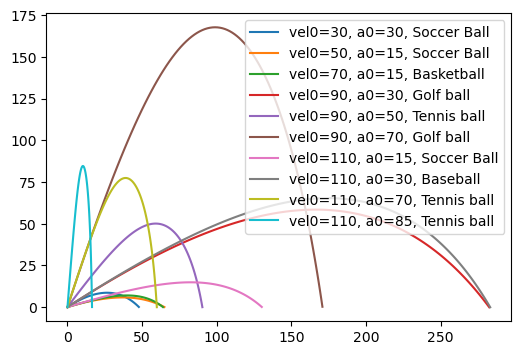

In [5]:
# plot some projectiles
r_task = 10
seed = 1
key, rng = random.split(random.PRNGKey(seed))
tasks = jnp.unique(random.choice(key, n_task, (r_task,), replace=False))

fig = plt.figure(figsize=(6, 4))
for task in tasks:
    vel0, a0, g, d, Cd, CArea, m, ball, a_t = task_all[task]
    label_x, label_y = label_xy[task][:,0], label_xy[task][:,1]
    plt.plot(label_x, label_y, label = 'vel0=%d, a0=%d, %s'%(vel0, a0, balls[int(ball)]));
plt.legend();

Baldwinian PINN (B-PINN)

In [6]:
# construct randomization B-PINN for linear/nonlinear ODE/PDEs
@jit
def get_f(t, weights):
    f = jnp.hstack([jnp.sin(t * weights[0] + weights[1]),
                    nn.softplus(t * weights[2] + weights[3]),
                    jnp.tanh(t * weights[4] + weights[5]),
                    jnp.sin(t * weights[6] + weights[7]),
                    nn.softplus(t * weights[8] + weights[9]),
                    jnp.tanh(t * weights[10] + weights[11])])
    return f

# obtain f_t
def get_f_t(get_f, t, weights):
    f_t = jacfwd(get_f)(t, weights)
    return f_t

#obtain f_tt
def get_f_tt(get_f, t, weights):
    f_tt = jacfwd(jacfwd(get_f))(t, weights)
    return f_tt

#f_vmap = vmap(get_f, in_axes=(0, None))
f_t_vmap = vmap(get_f_t, in_axes=(None, 0, None))
f_tt_vmap = vmap(get_f_tt, in_axes=(None, 0, None))

Least square problem

In [7]:
# no. neurons
n_node = 150

# generate weight & bias dist.
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
weights_n = random.truncated_normal(key, shape=(n_node, 6), lower=-1, upper=1)
key, rng = random.split(rng) # update random generator
weights_u = random.uniform(key, (n_node, 6), minval=-1, maxval=1)

# regularization
lamb = 1e-4

In [8]:
# compute hidden node outputs / derivaties & construct least square problem
@jit
def compute_ssr_task(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:6] + param[6:12], weights_u* param[12:18] + param[18:-1]]).T
    # generate coefs & sample (given task)
    vel0, a0, g, d, Cd, CArea, m, ball, a_T = task_all[task]
    u0 = vel0 * jnp.cos(a0*jnp.pi/180)
    v0 = vel0 * jnp.sin(a0*jnp.pi/180)
    t = jnp.linspace(0, a_T, n_data).reshape(-1, 1)
    label_x, label_y = label_xy[task][:,0].reshape(-1, 1), label_xy[task][:,1].reshape(-1, 1)
    # populate PDE sub-matrix
    f_t = f_t_vmap(get_f, t, weights)[:,:,0]
    f_tt = f_tt_vmap(get_f, t, weights)[:,:,0,0]
    pad00 = jnp.zeros((f_t.shape))
    # PDE 1: x_tt + R*x_t = 0
    # PDE 2: y_tt + R*y_t = -g
    # first iteration - R=0
    C = 0.5 * d * Cd * CArea / m
    R = 0
    pde_1 = jnp.hstack([f_tt + R*f_t, pad00])
    pde_2 = jnp.hstack([pad00, f_tt + R*f_t])
    # populate IC sub-matrix
    f_ic = get_f(t[0], weights)
    ic_1 = jnp.hstack([f_t, pad00])[0]
    ic_2 = jnp.hstack([pad00, f_t])[0]
    ic_3 = jnp.hstack([f_ic, pad00[0]])
    ic_4 = jnp.hstack([pad00[0], f_ic])
    # construct least square problem - populate A (w_x, w_y)
    A = jnp.vstack([pde_1, pde_2, ic_1, ic_2, ic_3, ic_4])
    # construct least square problem - populate b
    pad0 = jnp.zeros((n_data, 1))
    b = jnp.vstack([pad0, pad0 - g, u0, v0, x0, y0]) 
    # alternative solve (n_sample >> n_node & n_node >> n_sample)
    reg = lamb * param[-1]
    #w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    w = A.T@jnp.linalg.inv(reg*jnp.eye(A.shape[0]) + (A@A.T))@b
    # nonlinear iteration
    tot_iter = 15
    for i in range(tot_iter - 1):
        # update R
        x_t, y_t = jnp.hstack([f_t, pad00]) @ w, jnp.hstack([pad00, f_t]) @ w
        V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
        R = C*V
        pde_1 = jnp.hstack([f_tt + R*f_t, pad00])
        pde_2 = jnp.hstack([pad00, f_tt + R*f_t])
        # update A (w_x, w_y)
        A = jnp.vstack([pde_1, pde_2, ic_1, ic_2, ic_3, ic_4])
        # alternative solve (n_sample >> n_node & n_node >> n_sample)
        #w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
        w = A.T@jnp.linalg.inv(reg*jnp.eye(A.shape[0]) + (A@A.T))@b
    ssr = np.sum((b - A @ w)**2)
    # mse (given task)
    f = get_f(t, weights)
    pad00 = jnp.zeros(f.shape)
    x, y = jnp.hstack([f, pad00]) @ w, jnp.hstack([pad00, f]) @ w
    mse = jnp.mean((jnp.hstack([label_x, label_y]) - jnp.hstack([x, y]))**2)
    return ssr, mse

compute_ssr_task = jax.vmap(compute_ssr_task)
batch_ssr_task = jax.pmap(compute_ssr_task)

In [9]:
# solution
def get_u(t, weights):
    f = get_f(t, weights)
    pad00 = jnp.zeros(f.shape)
    x, y = np.hstack([f, pad00]) @ w, np.hstack([pad00, f]) @ w
    return (x, y)

In [10]:
from evojax.algo import CMA_ES_JAX

stdev = 0.5
pop_size = 20
solver = CMA_ES_JAX(
         pop_size=pop_size, init_stdev=stdev, # adjust pop_size and init_stdev (e.g., 0.1, 0.5, 1, 5, 10)
         param_size=25, seed=seed)

# no. task to choose from a distribution
r_task = 30

In [11]:
max_iters = 400

store = []
convergence = []

runtime = 0
train_iter = 0
while (runtime < 6000) and (train_iter < max_iters):
    start = time.time()
    # fitness evaluation
    params = solver.ask()
    # store weights after 1 & 400 iterations
    if ((train_iter + 1) == 1) | ((train_iter + 1) == 400):
        store.append(params)
    # repeat for a distribution of task (pop_size * r_task)
    params = jnp.tile(params, (r_task, 1)) # repeat for a distribution of task
    key, rng = random.split(rng) # update random generator
    tasks = random.choice(key, n_task, (r_task,), replace=False)
    tasks = jnp.repeat(tasks, repeats=pop_size) # repeat for each candidate solution
    # multi GPU runs
    ssr, mse = batch_ssr_task(params.reshape(n_gpu, int(len(params)/n_gpu), -1), tasks.reshape(n_gpu, -1))
    #ssr, mse = ssr.flatten(), mse.flatten()
    ssr = ssr.reshape(-1, pop_size).mean(axis=0)
    mse = mse.reshape(-1, pop_size).mean(axis=0)
    # updates the weights through the solver
    scores = - (mse + ssr)
    solver.tell(fitness=scores)
    # this is the average loss of all the population of parameters
    maxpos = jnp.argmax(scores)
    end = time.time()
    # update
    runtime += (end - start)
    # print out
    print('Iter = %5d | Time = %.2fs | LOSS = %.2e  || - SSR = %.2e, MSE = %.2e' % (train_iter + 1, runtime, -scores[maxpos],
                                                                                    ssr[maxpos], mse[maxpos]))
    convergence.append([train_iter + 1, runtime, -scores[maxpos], ssr[maxpos], mse[maxpos]])
    train_iter += 1
    
store = jnp.array(store)
convergence = jnp.array(convergence)

Iter =     1 | Time = 11.48s | LOSS = 1.82e+00  || - SSR = 1.82e+00, MSE = 1.50e-03
Iter =     2 | Time = 15.90s | LOSS = 1.00e-01  || - SSR = 9.99e-02, MSE = 5.19e-05
Iter =     3 | Time = 19.83s | LOSS = 1.02e-02  || - SSR = 1.02e-02, MSE = 4.35e-06
Iter =     4 | Time = 23.77s | LOSS = 3.11e-03  || - SSR = 3.11e-03, MSE = 4.77e-07
Iter =     5 | Time = 27.71s | LOSS = 3.18e-03  || - SSR = 3.17e-03, MSE = 4.44e-06
Iter =     6 | Time = 31.64s | LOSS = 2.73e-03  || - SSR = 2.72e-03, MSE = 9.12e-06
Iter =     7 | Time = 35.58s | LOSS = 6.04e-04  || - SSR = 5.87e-04, MSE = 1.73e-05
Iter =     8 | Time = 39.54s | LOSS = 6.65e-04  || - SSR = 6.62e-04, MSE = 3.01e-06
Iter =     9 | Time = 43.49s | LOSS = 6.71e-04  || - SSR = 5.39e-04, MSE = 1.32e-04
Iter =    10 | Time = 47.45s | LOSS = 3.62e-04  || - SSR = 3.51e-04, MSE = 1.08e-05
Iter =    11 | Time = 51.41s | LOSS = 2.50e-04  || - SSR = 1.92e-04, MSE = 5.80e-05
Iter =    12 | Time = 55.36s | LOSS = 1.41e-04  || - SSR = 6.04e-05, MSE = 8

Iter =    98 | Time = 395.93s | LOSS = 8.48e-06  || - SSR = 4.87e-06, MSE = 3.60e-06
Iter =    99 | Time = 399.91s | LOSS = 6.40e-06  || - SSR = 4.12e-06, MSE = 2.28e-06
Iter =   100 | Time = 403.89s | LOSS = 3.88e-06  || - SSR = 3.68e-06, MSE = 2.03e-07
Iter =   101 | Time = 407.87s | LOSS = 3.49e-06  || - SSR = 2.81e-06, MSE = 6.85e-07
Iter =   102 | Time = 411.85s | LOSS = 3.26e-06  || - SSR = 1.97e-06, MSE = 1.29e-06
Iter =   103 | Time = 415.84s | LOSS = 1.79e-06  || - SSR = 1.78e-06, MSE = 1.14e-08
Iter =   104 | Time = 419.81s | LOSS = 4.52e-06  || - SSR = 4.35e-06, MSE = 1.69e-07
Iter =   105 | Time = 423.80s | LOSS = 3.24e-06  || - SSR = 3.04e-06, MSE = 2.06e-07
Iter =   106 | Time = 427.78s | LOSS = 3.47e-06  || - SSR = 2.10e-06, MSE = 1.37e-06
Iter =   107 | Time = 431.76s | LOSS = 3.40e-06  || - SSR = 2.86e-06, MSE = 5.30e-07
Iter =   108 | Time = 435.74s | LOSS = 5.32e-06  || - SSR = 4.89e-06, MSE = 4.26e-07
Iter =   109 | Time = 439.72s | LOSS = 1.55e-06  || - SSR = 1.45e

Iter =   195 | Time = 782.13s | LOSS = 1.37e-06  || - SSR = 8.93e-07, MSE = 4.74e-07
Iter =   196 | Time = 786.11s | LOSS = 1.11e-06  || - SSR = 9.85e-07, MSE = 1.29e-07
Iter =   197 | Time = 790.09s | LOSS = 1.23e-06  || - SSR = 1.22e-06, MSE = 1.49e-08
Iter =   198 | Time = 794.08s | LOSS = 7.51e-07  || - SSR = 7.08e-07, MSE = 4.30e-08
Iter =   199 | Time = 798.06s | LOSS = 1.25e-06  || - SSR = 1.17e-06, MSE = 7.83e-08
Iter =   200 | Time = 802.04s | LOSS = 1.49e-06  || - SSR = 1.41e-06, MSE = 8.19e-08
Iter =   201 | Time = 806.02s | LOSS = 1.44e-06  || - SSR = 1.18e-06, MSE = 2.62e-07
Iter =   202 | Time = 810.01s | LOSS = 1.55e-06  || - SSR = 1.46e-06, MSE = 8.47e-08
Iter =   203 | Time = 813.99s | LOSS = 1.64e-06  || - SSR = 1.51e-06, MSE = 1.21e-07
Iter =   204 | Time = 817.97s | LOSS = 1.33e-06  || - SSR = 1.31e-06, MSE = 1.98e-08
Iter =   205 | Time = 821.95s | LOSS = 8.36e-07  || - SSR = 8.15e-07, MSE = 2.05e-08
Iter =   206 | Time = 825.93s | LOSS = 1.43e-06  || - SSR = 1.39e

Iter =   291 | Time = 1164.38s | LOSS = 3.29e-07  || - SSR = 3.01e-07, MSE = 2.79e-08
Iter =   292 | Time = 1168.36s | LOSS = 2.70e-07  || - SSR = 2.56e-07, MSE = 1.40e-08
Iter =   293 | Time = 1172.34s | LOSS = 3.49e-07  || - SSR = 2.55e-07, MSE = 9.37e-08
Iter =   294 | Time = 1176.32s | LOSS = 3.83e-07  || - SSR = 3.50e-07, MSE = 3.32e-08
Iter =   295 | Time = 1180.30s | LOSS = 4.52e-07  || - SSR = 3.64e-07, MSE = 8.72e-08
Iter =   296 | Time = 1184.28s | LOSS = 3.12e-07  || - SSR = 2.91e-07, MSE = 2.07e-08
Iter =   297 | Time = 1188.26s | LOSS = 4.19e-07  || - SSR = 3.34e-07, MSE = 8.58e-08
Iter =   298 | Time = 1192.25s | LOSS = 4.91e-07  || - SSR = 3.65e-07, MSE = 1.26e-07
Iter =   299 | Time = 1196.23s | LOSS = 5.37e-07  || - SSR = 4.48e-07, MSE = 8.94e-08
Iter =   300 | Time = 1200.21s | LOSS = 4.41e-07  || - SSR = 3.80e-07, MSE = 6.05e-08
Iter =   301 | Time = 1204.19s | LOSS = 3.35e-07  || - SSR = 2.88e-07, MSE = 4.67e-08
Iter =   302 | Time = 1208.17s | LOSS = 6.99e-07  || -

Iter =   387 | Time = 1546.58s | LOSS = 3.74e-07  || - SSR = 2.83e-07, MSE = 9.10e-08
Iter =   388 | Time = 1550.56s | LOSS = 3.01e-07  || - SSR = 2.71e-07, MSE = 3.05e-08
Iter =   389 | Time = 1554.54s | LOSS = 3.45e-07  || - SSR = 2.88e-07, MSE = 5.67e-08
Iter =   390 | Time = 1558.53s | LOSS = 3.46e-07  || - SSR = 2.95e-07, MSE = 5.15e-08
Iter =   391 | Time = 1562.51s | LOSS = 3.17e-07  || - SSR = 2.71e-07, MSE = 4.58e-08
Iter =   392 | Time = 1566.49s | LOSS = 3.76e-07  || - SSR = 2.86e-07, MSE = 9.05e-08
Iter =   393 | Time = 1570.47s | LOSS = 3.85e-07  || - SSR = 2.97e-07, MSE = 8.80e-08
Iter =   394 | Time = 1574.45s | LOSS = 2.54e-07  || - SSR = 1.97e-07, MSE = 5.75e-08
Iter =   395 | Time = 1578.43s | LOSS = 3.10e-07  || - SSR = 2.61e-07, MSE = 4.83e-08
Iter =   396 | Time = 1582.41s | LOSS = 2.50e-07  || - SSR = 2.13e-07, MSE = 3.72e-08
Iter =   397 | Time = 1586.39s | LOSS = 3.59e-07  || - SSR = 2.73e-07, MSE = 8.59e-08
Iter =   398 | Time = 1590.38s | LOSS = 3.27e-07  || -

In [12]:
solver.best_params

DeviceArray([-4.81970537e+00, -5.61531590e+00,  7.13371875e-01,
              1.13116383e+01,  5.59125160e+00,  6.94214365e-01,
              1.61085814e+00,  1.74251020e+00, -5.82839268e+00,
             -1.25143652e+00, -2.95316714e+00, -2.30659384e+00,
             -3.94103919e+00,  3.57746423e+00, -3.19837198e+00,
              1.17288572e+01, -9.53965433e-01,  3.12007250e+00,
             -4.65941287e-02,  5.29778376e+00, -8.37846168e-01,
              4.95743171e+00, -1.47761316e+00,  4.01964398e+00,
              1.00141438e-02], dtype=float64)

Convergence & prediction on [ test ] tasks

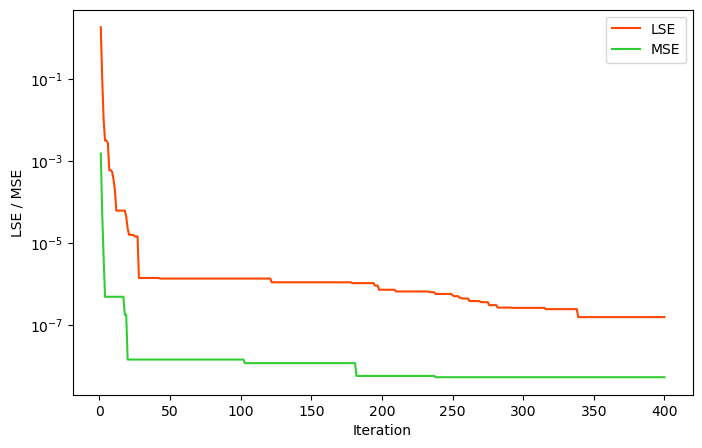

In [14]:
# plot convergence
fig = plt.figure(figsize=(8, 5))
# smooth the MSE & SSR
_mse = np.array(convergence[:,4].copy())
for i in range(1, len(_mse)): _mse[i] = min(_mse[i], _mse[i-1])  
_ssr = np.array(convergence[:,3].copy())
for i in range(1, len(_ssr)): _ssr[i] = min(_ssr[i], _ssr[i-1])  
plt.plot(convergence[:,0], _ssr, label='LSE', c='orangered');
plt.plot(convergence[:,0], _mse, label='MSE', c='limegreen');
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('LSE / MSE'); plt.legend(); #plt.ylim(1e-10, 1e1);

In [15]:
# task / problem
nballs = ['Baseball   ', 'Basketball ', 'Golf ball  ', 'Soccer Ball', 'Tennis ball']

In [16]:
# load new tasks and target label
ntask_all = jnp.load(os.path.join('data_meta_pdes', 'pms_test_task.npy'))
nlabel_xy = jnp.load(os.path.join('data_meta_pdes', 'pms_test_label.npy'))
print (ntask_all.shape, nlabel_xy.shape)

(100, 9) (100, 101, 2)


In [17]:
# compute hidden node outputs / derivaties & construct least square problem for new task
@jit
def compute_ls_ntask(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:6] + param[6:12], weights_u* param[12:18] + param[18:-1]]).T
    # generate coefs & sample (given task)
    vel0, a0, g, d, Cd, CArea, m, ball, a_T = ntask_all[task]
    u0 = vel0 * jnp.cos(a0*jnp.pi/180)
    v0 = vel0 * jnp.sin(a0*jnp.pi/180)
    t = jnp.linspace(0, a_T, n_data).reshape(-1, 1)
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    # populate PDE sub-matrix
    f_t = f_t_vmap(get_f, t, weights)[:,:,0]
    f_tt = f_tt_vmap(get_f, t, weights)[:,:,0,0]
    pad00 = jnp.zeros((f_t.shape))
    # PDE 1: x_tt + R*x_t = 0
    # PDE 2: y_tt + R*y_t = -g
    # first iteration - R=0
    C = 0.5 * d * Cd * CArea / m
    R = 0
    pde_1 = jnp.hstack([f_tt + R*f_t, pad00])
    pde_2 = jnp.hstack([pad00, f_tt + R*f_t])
    # populate IC sub-matrix
    f_ic = get_f(t[0], weights)
    ic_1 = jnp.hstack([f_t, pad00])[0]
    ic_2 = jnp.hstack([pad00, f_t])[0]
    ic_3 = jnp.hstack([f_ic, pad00[0]])
    ic_4 = jnp.hstack([pad00[0], f_ic])
    # construct least square problem - populate A (w_x, w_y)
    A = jnp.vstack([pde_1, pde_2, ic_1, ic_2, ic_3, ic_4])
    # construct least square problem - populate b
    pad0 = jnp.zeros((n_data, 1))
    b = jnp.vstack([pad0, pad0 - g, u0, v0, x0, y0]) 
    # alternative solve (n_sample >> n_node & n_node >> n_sample)
    reg = lamb * param[-1]
    #w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    w = A.T@jnp.linalg.inv(reg*jnp.eye(A.shape[0]) + (A@A.T))@b
    # nonlinear iteration
    tot_iter = 15
    for i in range(tot_iter - 1):
        # update R
        x_t, y_t = jnp.hstack([f_t, pad00]) @ w, jnp.hstack([pad00, f_t]) @ w
        V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
        R = C*V
        pde_1 = jnp.hstack([f_tt + R*f_t, pad00])
        pde_2 = jnp.hstack([pad00, f_tt + R*f_t])
        # update A (w_x, w_y)
        A = jnp.vstack([pde_1, pde_2, ic_1, ic_2, ic_3, ic_4])
        # alternative solve (n_sample >> n_node & n_node >> n_sample)
        #w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
        w = A.T@jnp.linalg.inv(reg*jnp.eye(A.shape[0]) + (A@A.T))@b
    ssr = jnp.sum((b - A @ w)**2)
    return w, ssr, weights

In [18]:
# prediction on test tasks
res_test = []
for task in range(len(ntask_all)):
    vel0, a0, g, d, Cd, CArea, m, ball, a_T = ntask_all[task]
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    t = jnp.linspace(0, a_T, n_data).reshape(-1, 1)
    # solve problem
    w, ssr, weights = compute_ls_ntask(solver.best_params, task)
    x, y = get_u(t, weights)
    mse = jnp.mean((jnp.hstack([label_x, label_y]) - jnp.hstack([x, y]))**2)
    #print('vel0=%02d, a0=%d, %s | SSR = %.2e | MSE = %.2e'%(vel0, a0, balls[int(ball)], ssr, mse));
    res_test.append([vel0, a0, ball, ssr, mse])

# summary statistics
res_test = pd.DataFrame(jnp.array(res_test), columns=['vel0', 'a0', 'ball', 'SSR', 'MSE'])
res_test['MSE'].describe()    

count    1.000000e+02
mean     2.289123e-08
std      7.141687e-08
min      1.764618e-13
25%      3.442882e-11
50%      1.383937e-10
75%      2.277317e-09
max      3.828385e-07
Name: MSE, dtype: float64

Prediction on selected test tasks - showing Baldwinian evolution progress

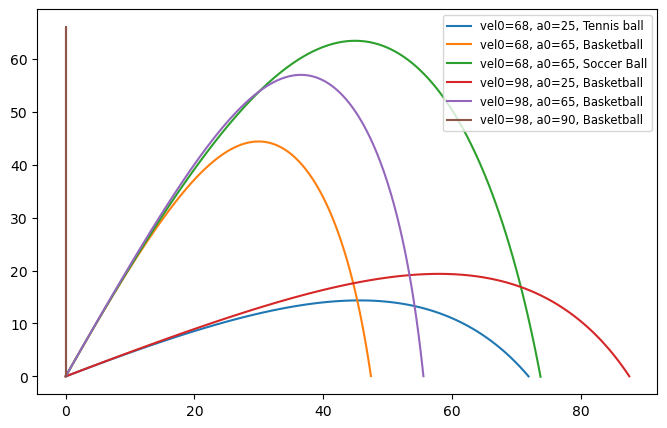

In [20]:
# plot some projectiles
r_task = 6
key, rng = random.split(random.PRNGKey(1))
tasks = jnp.unique(random.choice(key, len(ntask_all)/2, (r_task,), replace=False)) + 50 + 2

fig = plt.figure(figsize=(8, 5))
for task in tasks:
    vel0, a0, g, d, Cd, CArea, m, ball, a_t = ntask_all[task]
    label_x, label_y = nlabel_xy[task][:,0], nlabel_xy[task][:,1]
    plt.plot(label_x, label_y, label = 'vel0=%d, a0=%d, %s'%(vel0, a0, nballs[int(ball)]));
plt.legend(ncol=1, fontsize='small', loc='upper right');

After 1 iteration

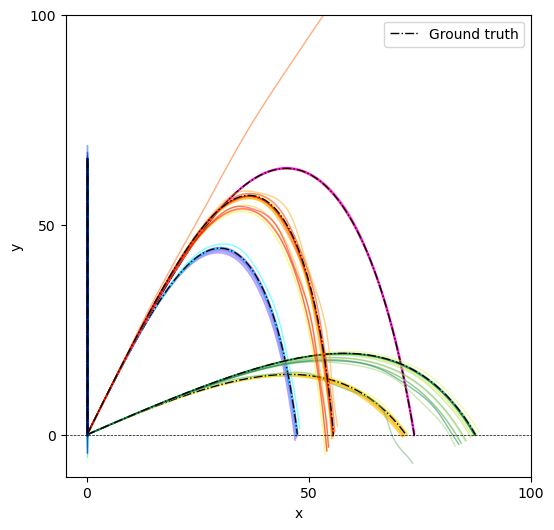

In [21]:
res_test_x, res_test_y = [], []
for task in tasks:
    vel0, a0, g, d, Cd, CArea, m, ball, a_T = ntask_all[task]
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    t = jnp.linspace(0, a_T, n_data).reshape(-1, 1)
    # solve problem
    for param in store[0]:
        w, ssr, weights = compute_ls_ntask(param, task)
        x, y = get_u(t, weights)
        res_test_x.append(x)
        res_test_y.append(y)
        mse = jnp.mean((jnp.hstack([label_x, label_y]) - jnp.hstack([x, y]))**2)
        #print('vel0=%d, a0=%d, %s | SSR = %.2e | MSE = %.2e'%(vel0, a0, balls[int(ball)], ssr, mse));

# plot
fig = plt.figure(figsize=(6, 6))
colors = [plt.cm.Wistia_r(np.linspace(0, 1, 20)), plt.cm.cool_r(np.linspace(0, 1, 20)),
          plt.cm.spring_r(np.linspace(0, 1, 20)), plt.cm.summer_r(np.linspace(0, 1, 20)),
          plt.cm.autumn_r(np.linspace(0, 1, 20)), plt.cm.winter_r(np.linspace(0, 1, 20))]
for t in range(6):
    task = tasks[t]
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    for i in range(0, 20):
        plt.plot(res_test_x[t*20+i], res_test_y[t*20+i], color=colors[t][i], lw=1., alpha=.5);
    plt.plot(label_x, label_y, c='k', lw=1, linestyle='-.');
plt.plot(label_x, label_y, c='k', lw=1, linestyle='-.', label='Ground truth');
plt.xlabel('x'); plt.ylabel('y'); plt.ylim(-10, 100); plt.ylim(-10, 100);
plt.axhline(y=0, c='k', linestyle='--', lw=.5); plt.legend();
plt.xticks([0,50,100], [0,50,100]); plt.yticks([0,50,100], [0,50,100]);

After 400 iterations

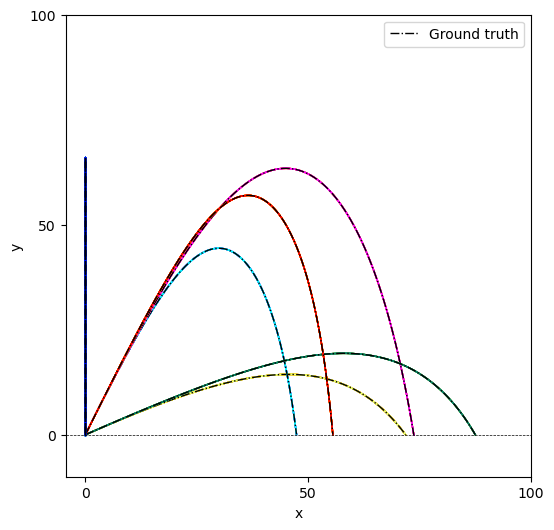

In [23]:
res_test_x, res_test_y = [], []
for task in tasks:
    vel0, a0, g, d, Cd, CArea, m, ball, a_T = ntask_all[task]
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    t = jnp.linspace(0, a_T, n_data).reshape(-1, 1)
    # solve problem
    for param in store[1]:
        w, ssr, weights = compute_ls_ntask(param, task)
        x, y = get_u(t, weights)
        res_test_x.append(x)
        res_test_y.append(y)
        mse = jnp.mean((jnp.hstack([label_x, label_y]) - jnp.hstack([x, y]))**2)
        #print('vel0=%d, a0=%d, %s | SSR = %.2e | MSE = %.2e'%(vel0, a0, balls[int(ball)], ssr, mse));
    
# plot
fig = plt.figure(figsize=(6, 6))
colors = [plt.cm.Wistia_r(np.linspace(0, 1, 20)), plt.cm.cool_r(np.linspace(0, 1, 20)),
          plt.cm.spring_r(np.linspace(0, 1, 20)), plt.cm.summer_r(np.linspace(0, 1, 20)),
          plt.cm.autumn_r(np.linspace(0, 1, 20)), plt.cm.winter_r(np.linspace(0, 1, 20))]
for t in range(6):
    task = tasks[t]
    label_x, label_y = nlabel_xy[task][:,0].reshape(-1, 1), nlabel_xy[task][:,1].reshape(-1, 1)
    for i in range(0, 20):
        plt.plot(res_test_x[t*20+i], res_test_y[t*20+i], color=colors[t][i], lw=1., alpha=.75);
    plt.plot(label_x, label_y, c='k', lw=1, linestyle='-.');
plt.plot(label_x, label_y, c='k', lw=1, linestyle='-.', label='Ground truth');
plt.xlabel('x'); plt.ylabel('y'); plt.ylim(-10, 100); plt.ylim(-10, 100);
plt.axhline(y=0, c='k', linestyle='--', lw=.5); plt.legend();
plt.xticks([0,50,100], [0,50,100]); plt.yticks([0,50,100], [0,50,100]);